In [ ]:
# lagged ensemble modeling https://meetingorganizer.copernicus.org/EGU2020/EGU2020-2680.html

In [1]:
import argparse
import os
import sys
import time, re
import numpy as np
import logging
from datetime import datetime, timedelta
from collections import OrderedDict


username="gupt1075"
# sys.path.append(os.path.dirname(os.path.realpath(__file__)) + '/../')

if (f"/home/{username}/FourCastNet_gil" not in sys.path):
    sys.path.append(f"/home/{username}/FourCastNet_gil")




import h5py
import torch
import torch.cuda.amp as amp
import torch.distributed as dist
import torch.nn as nn
import torchvision
from numpy.core.numeric import False_
from torch.nn.parallel import DistributedDataParallel
from torchvision.utils import save_image
from utils import logging_utils
from utils.weighted_acc_rmse import (
    unweighted_acc_torch_channels,
    weighted_acc_masked_torch_channels,
    weighted_acc_torch_channels,
    weighted_rmse_torch_channels,
)

import glob
from datetime import datetime, timedelta

import wandb
from networks.afnonet import AFNONet
from utils.data_loader_multifiles import get_data_loader
from utils.YParams import YParams
from scipy.stats import sem



/depot/gdsp/apps/FourCastNet/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:




# era sst


import netCDF4
from matplotlib import pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from datetime import datetime, timedelta
import matplotlib
from matplotlib import cm
import matplotlib.ticker as mticker
# import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# from matplotlib import animation
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
# plt.rcParams['animation.ffmpeg_path'] = '/home/gupt1075/FourCastNet/'


In [51]:

def load_data_from_h5(filename):

    # f = h5py.File(filename, "r")
    # numpy_arr = f["arr1"]
    # datetime_strings = f["input_ics"][:]
    # datetime_objects = [datetime.fromisoformat(dt.decode()) for dt in datetime_strings]    
    # f.close()  # Close the file after reading the data
    # return numpy_arr, datetime_objects
    
    with h5py.File(filename, "r+") as f:
        numpy_arr = np.copy(f["arr1"][:])
        datetime_strings = f["input_ics"][:]
        datetime_objects = [datetime.fromisoformat(dt.decode()) for dt in datetime_strings]        
        return numpy_arr, datetime_objects

In [68]:
def plot_dynamic(data, ics_dates, output_date="", fld="z500"):
    # fld="t850"
    channel_tags = {"u10": 0, "z500": 14, "2m_temperature": 2, "v10": 1, "t850": 5, "tcwv": 19}
    channel = channel_tags[fld]
    dim = data.shape[0]
    # Calculate the number of rows and columns for the subplots
    num_rows = dim
    num_cols = 1

    # Create the figure and subplots
    fig, axes = plt.subplots(num_rows, num_cols, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, figsize=(12, 24))

    # Iterate over the data and plot each array
    for i, ax in enumerate(axes.flat):
        if i < dim:
            ax.coastlines()
            out = ax.imshow(data[i, channel], cmap="coolwarm", origin='upper', extent=[0, 360, -90, 90], transform=ccrs.PlateCarree())
            ax.set_xticks([0, 60, 120, 180, 240, 300, 359.99], crs=ccrs.PlateCarree())
            ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
            fig.colorbar(out, ax=ax)
            ax.set_title(f"output_ics = {output_date} based on ics {ics_dates[i].strftime('%Y_%B_%d_%H')}")
            ax.axis('off')
        else:
            ax.axis('off')

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.tight_layout()
    plt.show()


In [31]:
# fld = "z500"

def get_base_path_without_extension(global_path):
    """
    Extracts the base path of a file without the extension from a given global path.
    
    Args:
        global_path (str): The long global path of the file.
        
    Returns:
        str: The base path of the file without the extension.
    """
    # Get the base name of the file (without the directory path)
    base_name = os.path.basename(global_path)
    
    # Remove the file extension from the base name
    base_name_without_ext = os.path.splitext(base_name)[0]
    
    # Get the directory path of the file
    directory_path = os.path.dirname(global_path)
    
    # Combine the directory path and the base name without the extension
    base_path_without_ext = os.path.join(directory_path, base_name_without_ext)
    
    return base_path_without_ext


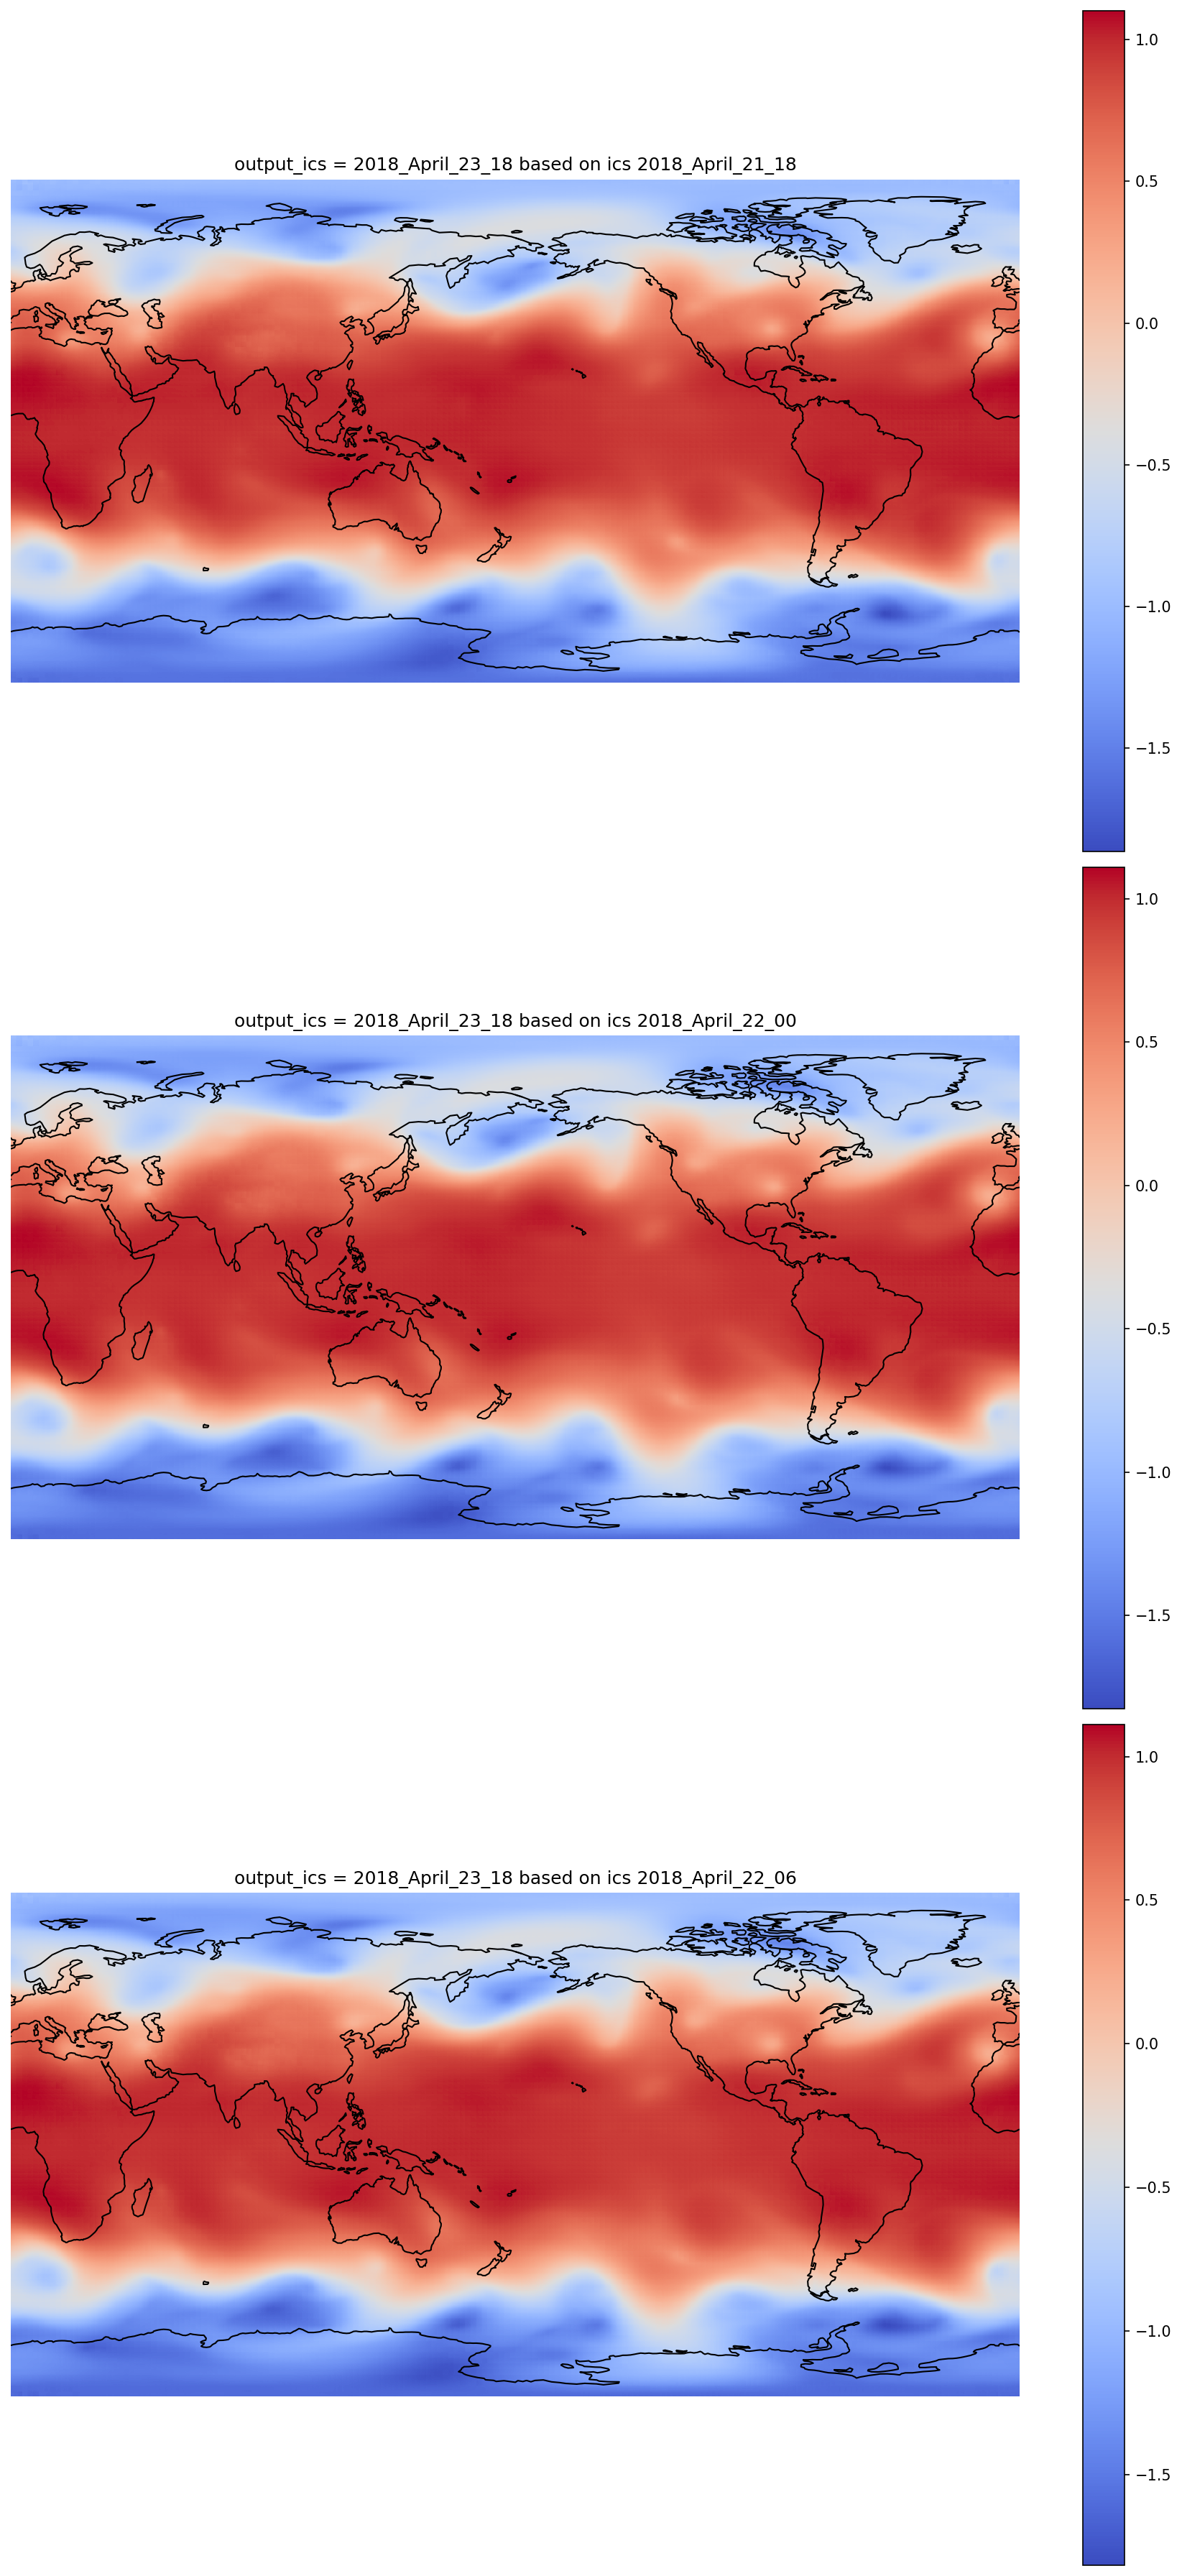

In [69]:

file_path = "/scratch/gilbreth/gupt1075/ERA5_ensemble_april_20_h5/afno_backbone/222/2018_April_23_18.h5"
numpy_arr_tmp, datetime_objects_tmp = load_data_from_h5(file_path)
plot_dynamic(numpy_arr_tmp, datetime_objects_tmp, output_date="2018_April_23_18", fld="z500")


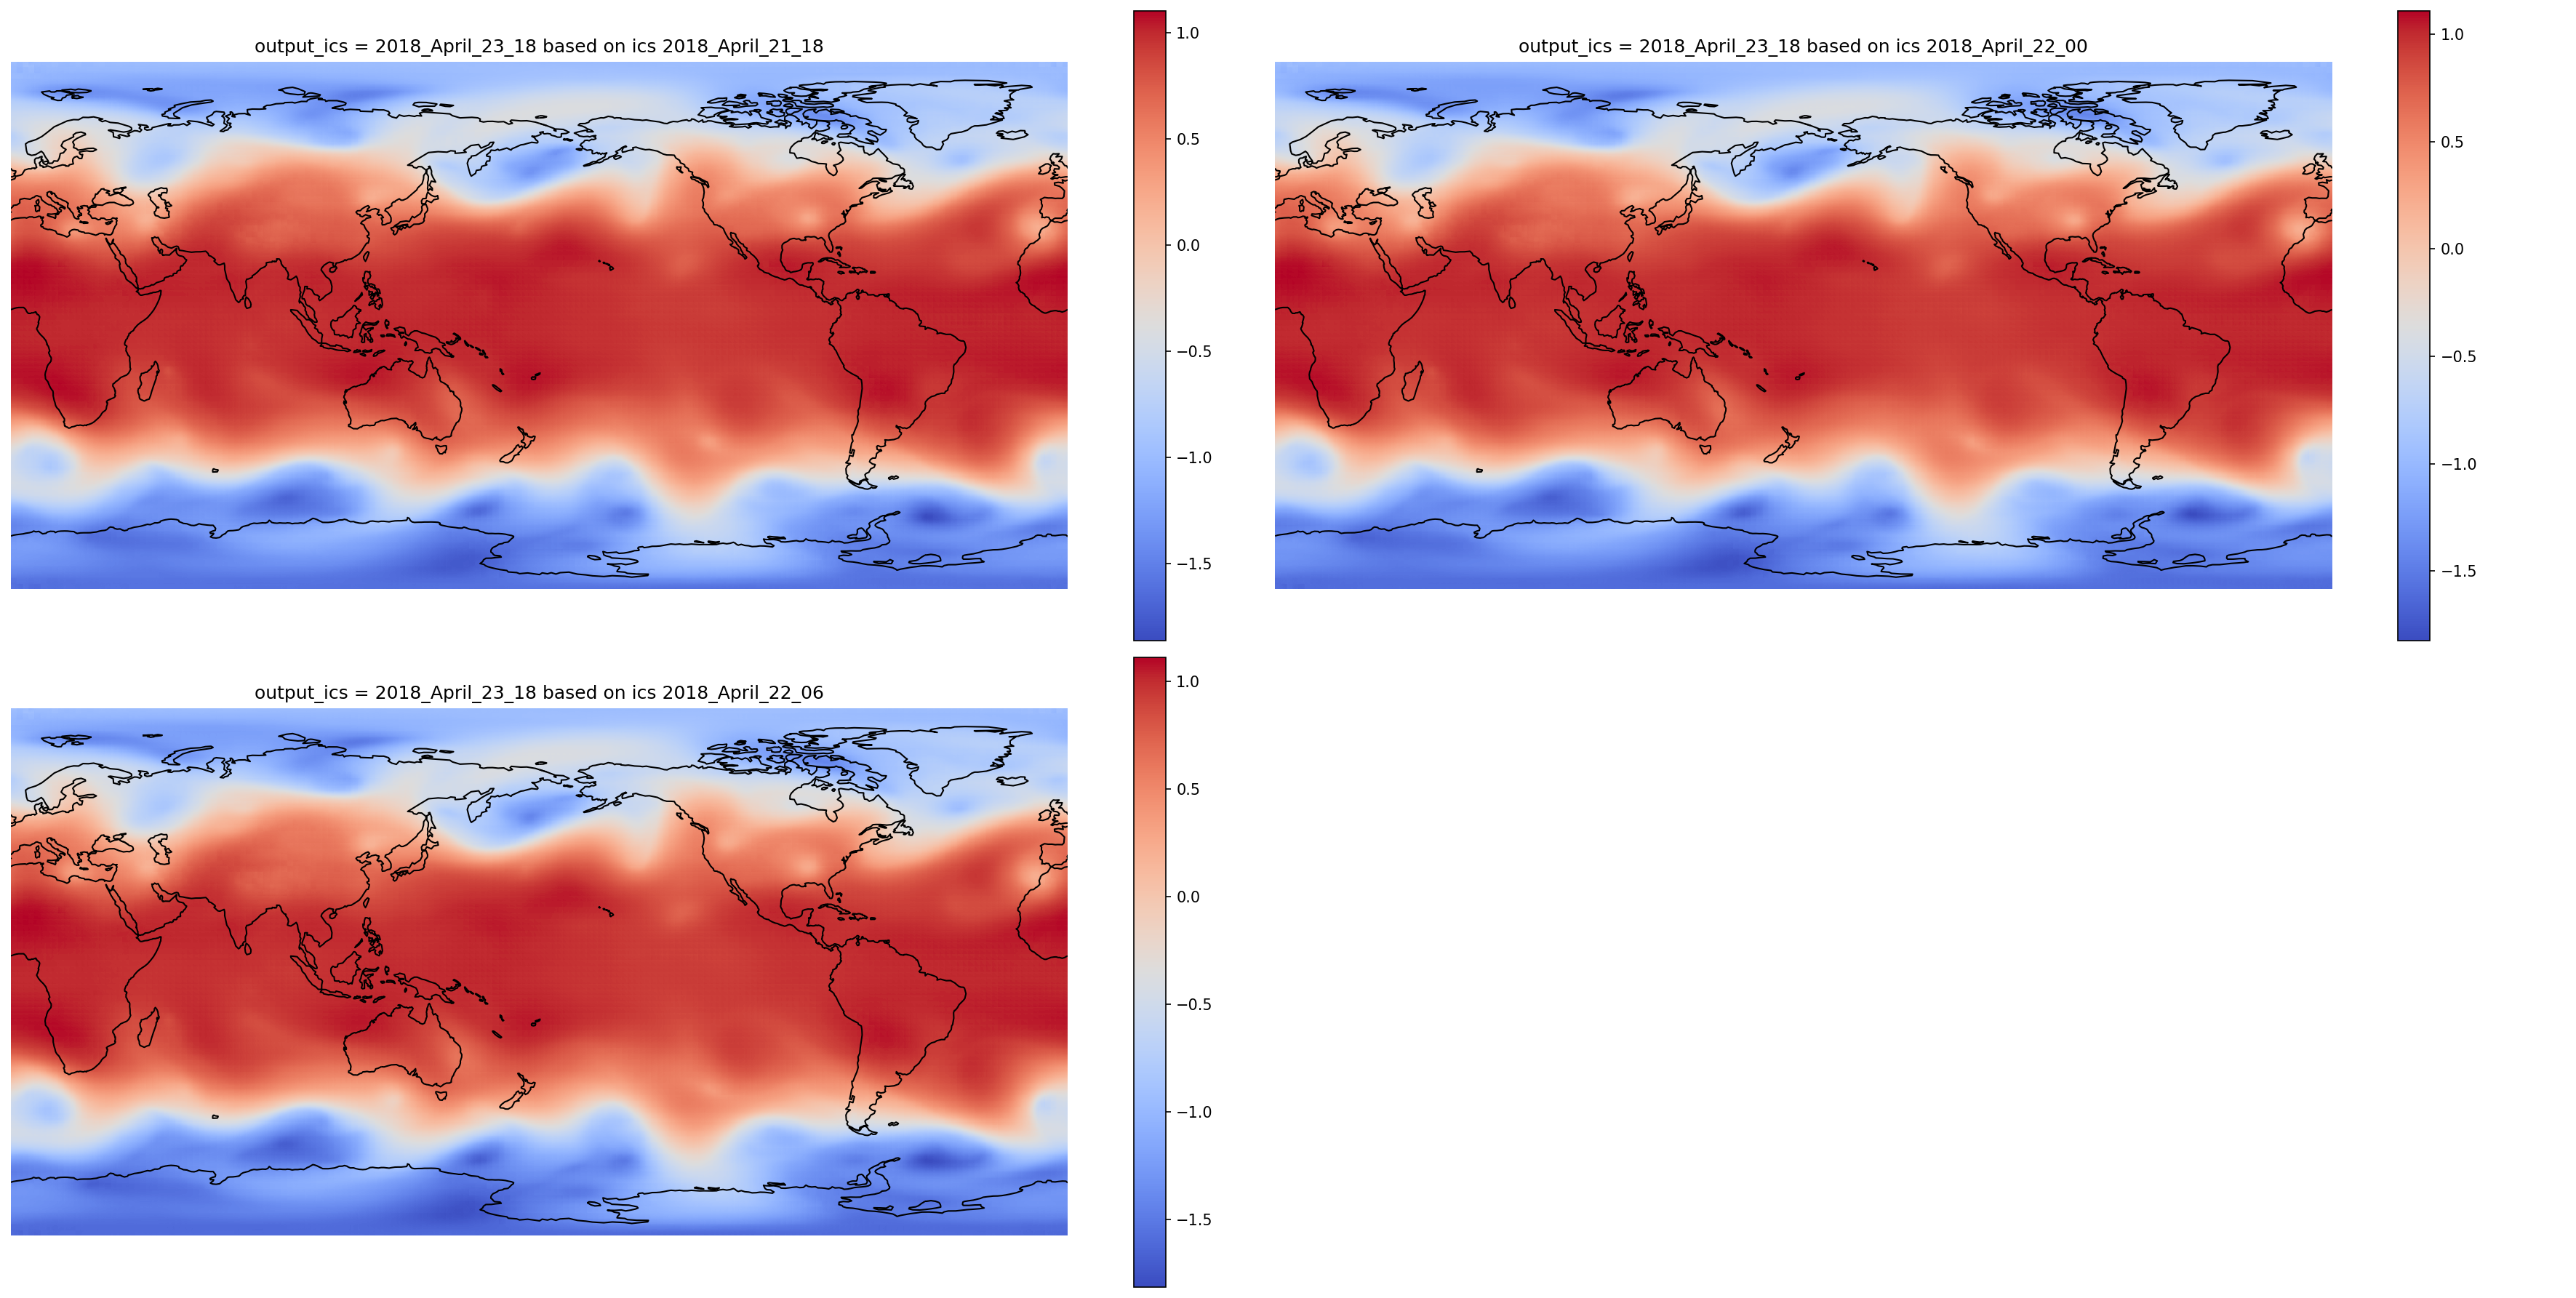

In [53]:
# file_path = "/scratch/gilbreth/gupt1075/ERA5_ensemble_april_20_h5/afno_backbone/222/2018_April_23_18.h5"
# numpy_arr_tmp, datetime_objects_tmp = load_data_from_h5(file_path)
# plot_dynamic(numpy_arr_tmp, datetime_objects_tmp, output_date="2018_April_23_18", fld="z500")


In [71]:

# ensemble_output_date_01_February_2018_ensemble_number_4
# Set the datetime format to search for in the filenames
datetime_format = '%Y_%B_%d_%H'

# Set the start and end dates to search for
start_date = datetime(2018, 4, 1, 0, 0, 0)
end_date = datetime(2018, 4, 30, 23, 59, 59)
directory = "/scratch/gilbreth/gupt1075/ERA5_ensemble_april_20_h5/afno_backbone/222/"


data_storage = []
ics_storage = []
filename_storage = []

# Loop through all files in the directory
for filename in sorted(os.listdir(directory))[:5]:
    # Check if the file is a NumPy file
    if filename.endswith('.h5'):
        
        # Try to extract the datetime from the filename
        try:
            file_datetime = datetime.strptime(filename.split('.')[0], datetime_format)

            if (start_date <= file_datetime <= end_date):

                file_path = os.path.join(directory, filename)
                print(f" filedatetime: {file_path} ")
                numpy_arr, ics_dates = load_data_from_h5(file_path)
                
                print(f' numpy_arr {numpy_arr.shape}  and datetime {datetime_objects} ')
                # plot_dynamic(numpy_arr, ics_dates, output_date=filename, fld="z500")
                
                data_storage.append(numpy_arr)
                ics_storage.append(ics_dates)
                filename_storage.append(filename)

        
        except ValueError:
            # If the filename doesn't match the expected format, skip the file
            pass

 filedatetime: /scratch/gilbreth/gupt1075/ERA5_ensemble_april_20_h5/afno_backbone/222/2018_April_21_06.h5 
 numpy_arr (1, 20, 720, 1440)  and datetime [datetime.datetime(2018, 4, 21, 18, 0), datetime.datetime(2018, 4, 22, 0, 0), datetime.datetime(2018, 4, 22, 6, 0)] 
 filedatetime: /scratch/gilbreth/gupt1075/ERA5_ensemble_april_20_h5/afno_backbone/222/2018_April_21_12.h5 
 numpy_arr (2, 20, 720, 1440)  and datetime [datetime.datetime(2018, 4, 21, 18, 0), datetime.datetime(2018, 4, 22, 0, 0), datetime.datetime(2018, 4, 22, 6, 0)] 
 filedatetime: /scratch/gilbreth/gupt1075/ERA5_ensemble_april_20_h5/afno_backbone/222/2018_April_21_18.h5 
 numpy_arr (3, 20, 720, 1440)  and datetime [datetime.datetime(2018, 4, 21, 18, 0), datetime.datetime(2018, 4, 22, 0, 0), datetime.datetime(2018, 4, 22, 6, 0)] 
 filedatetime: /scratch/gilbreth/gupt1075/ERA5_ensemble_april_20_h5/afno_backbone/222/2018_April_22_00.h5 
 numpy_arr (4, 20, 720, 1440)  and datetime [datetime.datetime(2018, 4, 21, 18, 0), datet

In [72]:
print(f" {data_storage[1].shape} {ics_storage[1]}  ")

 (2, 20, 720, 1440) [datetime.datetime(2018, 4, 21, 0, 0), datetime.datetime(2018, 4, 21, 6, 0)]  


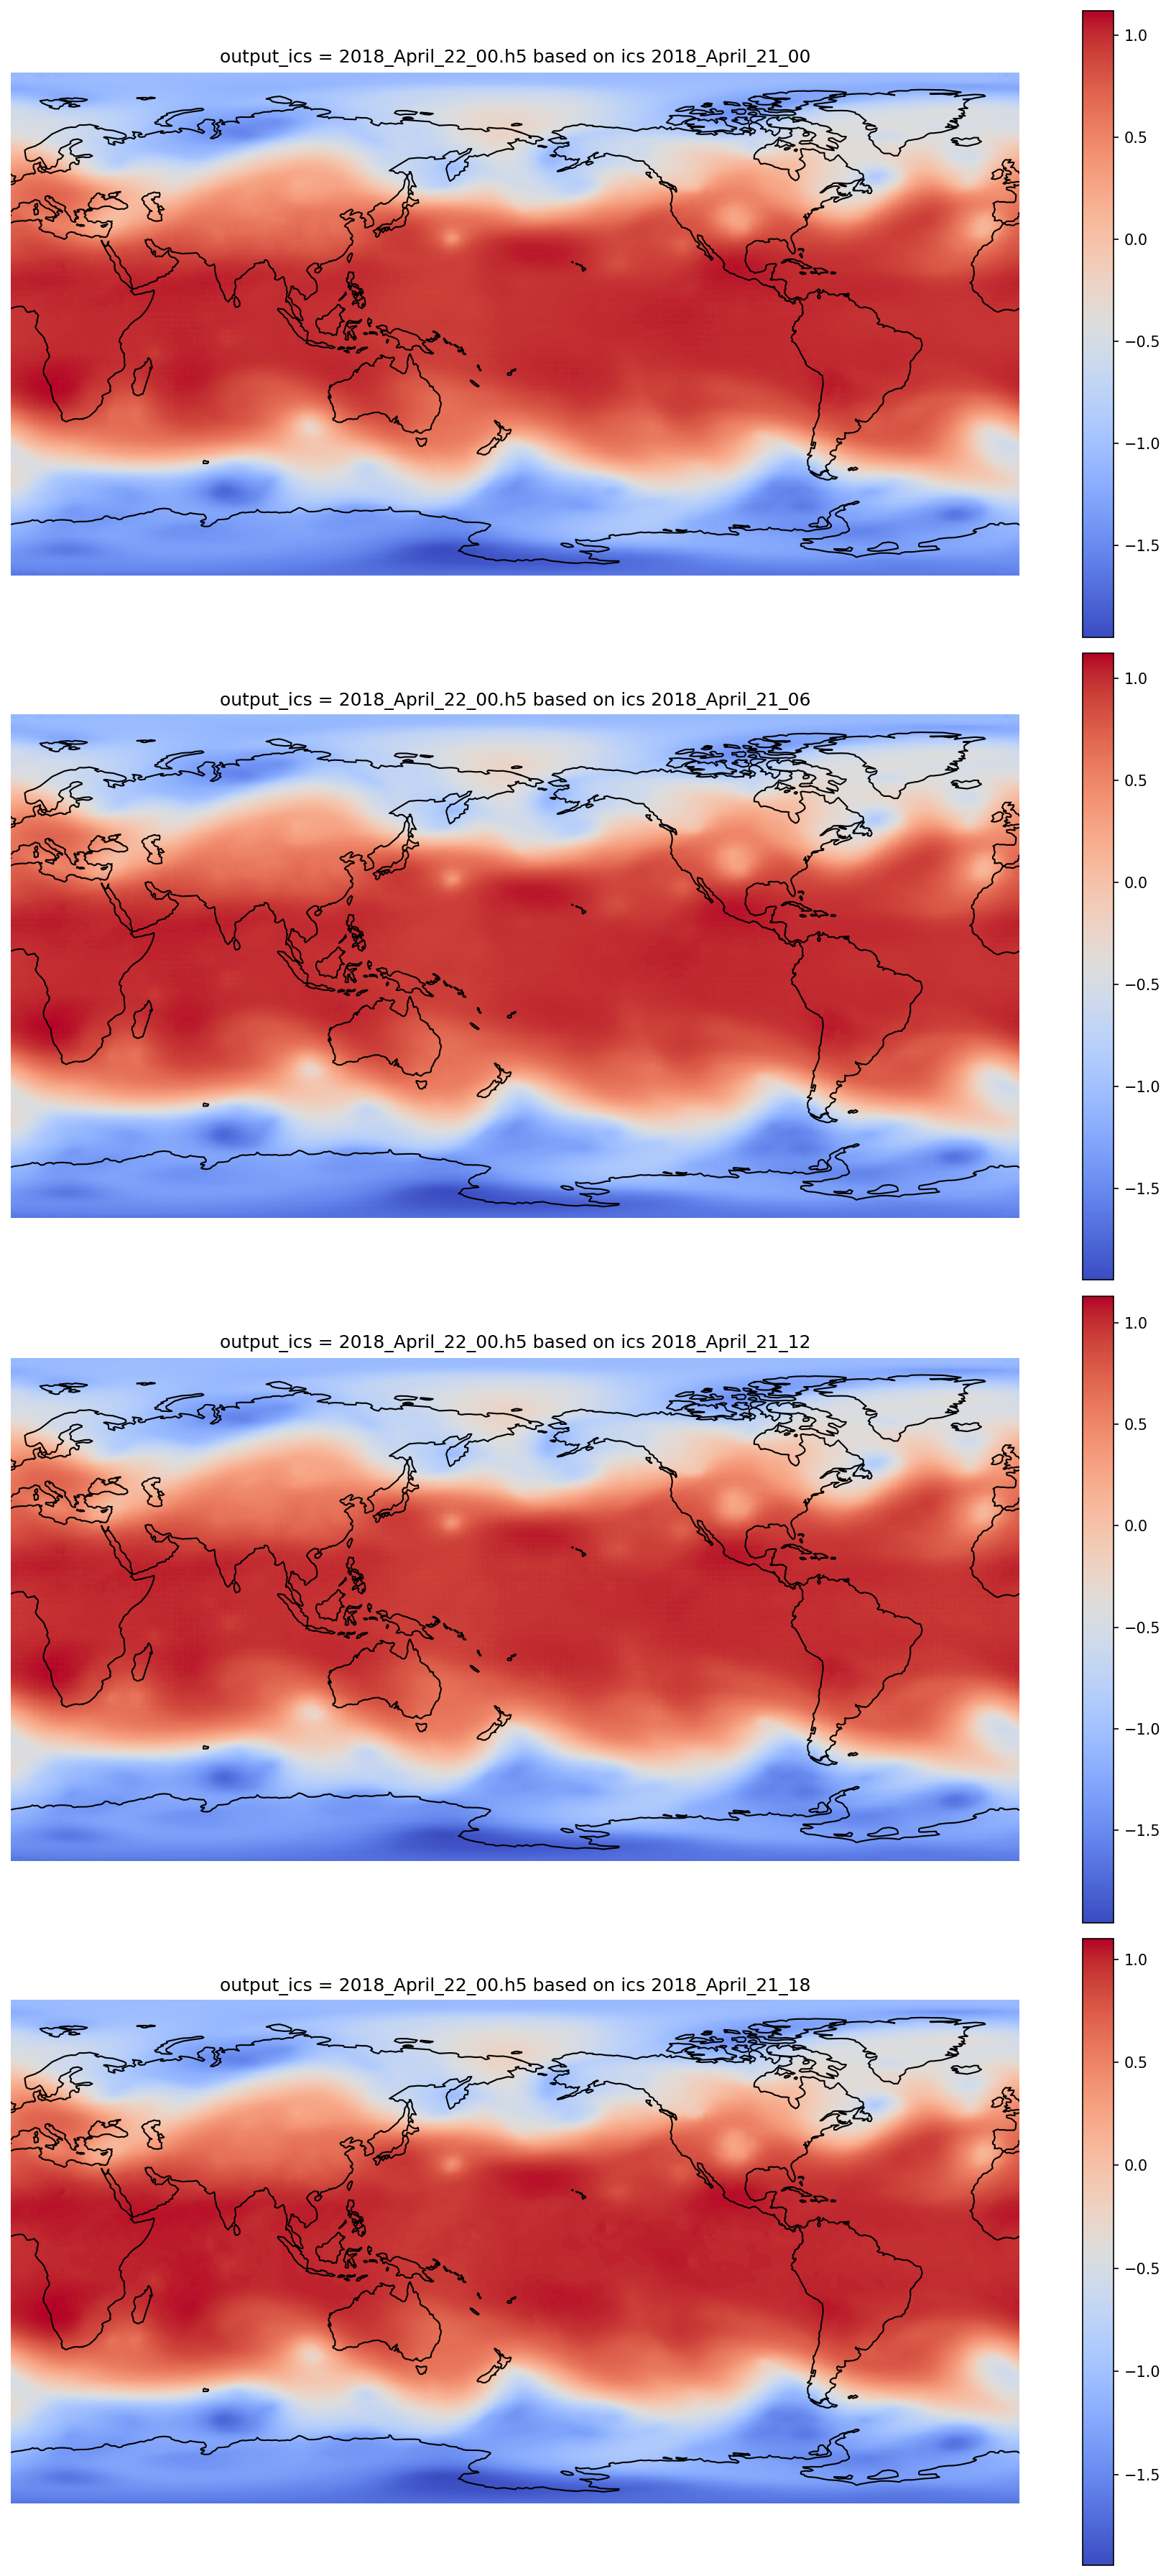

In [73]:

index_to_plot = 3

plot_dynamic(data_storage[index_to_plot], ics_storage[index_to_plot], output_date=filename_storage[index_to_plot], fld="z500")



# filepath = "2018_February_07_18.npy"

# filename = get_base_path_without_extension(filename_storage[index_to_plot])
# print(f" plotting filename {filename}  with shape {data_storage[index_to_plot].shape}    " )

# plot_data = data_storage[index_to_plot]
# plot_dynamic(plot_data, fld="z500")